- first part of codebase (https://github.com/makotu1208/open-problems-multimodal-3rd-solution/tree/main): model dictionary, prediction loop etc
- get model output
- on public data (=codebase) and on private data

In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables   
# necessary for pd.read_hdf()

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
!pip install catboost
!pip install shap
!pip install anndata

In [8]:
import os
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc 

import anndata as ad

from helper_functions import *

In [3]:
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

In [9]:
plt.rcParams['figure.dpi'] = 100
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.8


## data load

In [10]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'

# model_path_for_now = '/dss/dsshome1/02/di93zoj/valentina/open-problems-multimodal-3rd-solution/'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

# multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
# multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
# multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
# multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite   (from codebase)

prepare models

In [5]:
# short names of models used in ensemble
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [6]:
# create model_name_list containing the actual file name of each model from mlp_model_name
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

# len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [7]:
# list of file names: test sets that correspond to each model in model_name_list
# weights used for weighting model predictions in ensemble
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()    # == 19

# create dict of shape {model_name: [test set, weight]}
model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model   (from codebase)

In [8]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [9]:
# class CiteDataset(Dataset):
    
#     def __init__(self, feature, target):
        
#         self.feature = feature
#         self.target = target
        
#     def __len__(self):
#         return len(self.feature)
    
#     def __getitem__(self, index):
                
#         d = {
#             "X": self.feature[index],
#             "y" : self.target[index],
#         }
#         return d

In [10]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [11]:
# def partial_correlation_score_torch_faster(y_true, y_pred):
#     """Compute the correlation between each rows of the y_true and y_pred tensors.
#     Compatible with backpropagation.
#     """
#     y_true_centered = y_true - torch.mean(y_true, dim=1)[:,None]
#     y_pred_centered = y_pred - torch.mean(y_pred, dim=1)[:,None]
#     cov_tp = torch.sum(y_true_centered*y_pred_centered, dim=1)/(y_true.shape[1]-1)
#     var_t = torch.sum(y_true_centered**2, dim=1)/(y_true.shape[1]-1)
#     var_p = torch.sum(y_pred_centered**2, dim=1)/(y_true.shape[1]-1)
#     return cov_tp/torch.sqrt(var_t*var_p)

# def correl_loss(pred, tgt):
#     """Loss for directly optimizing the correlation.
#     """
#     return -torch.mean(partial_correlation_score_torch_faster(tgt, pred))

In [12]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [13]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [14]:
# def train_loop(model, optimizer, loader, epoch):
    
#     losses, lrs = [], []
#     model.train()
#     optimizer.zero_grad()
#     #loss_fn = nn.MSELoss()
    
#     with tqdm(total=len(loader),unit="batch") as pbar:
#         pbar.set_description(f"Epoch{epoch}")
        
#         for d in loader:
#             X = d['X'].to(device)
#             y = d['y'].to(device)
            
#             logits = model(X)
#             loss = correl_loss(logits, y)
#             #loss = torch.sqrt(loss_fn(logits, y))
        
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
            
#             pbar.set_postfix({"loss":loss.item()})
#             pbar.update(1)

#     return model

In [15]:
# def valid_loop(model, loader, y_val):
    
#     model.eval()
#     partial_correlation_scores = []
#     oof_pred = []
    
#     for d in loader:
#         with torch.no_grad():
#             val_X = d['X'].to(device).float()
#             val_y = d['y'].to(device)
#             logits = model(val_X)
#             oof_pred.append(logits)
    
#     #print(torch.cat(oof_pred).shape, torch.cat(oof_pred).detach().cpu().numpy().shape)
#     cor = partial_correlation_score_torch_faster(torch.tensor(y_val).to(device), torch.cat(oof_pred))
#     cor = cor.mean().item()
#     logits = torch.cat(oof_pred).detach().cpu().numpy()
    
#     return logits, cor

In [16]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### ensemble prediction: use all models, sum weighted predictions

In [17]:
pred = np.zeros([48203, 140])

for num, i in enumerate(model_feat_dict.keys()):
    
    print(i)
    
    if 'mlp' in i:

        try:
            test_file = model_feat_dict[i][0]
            test_weight = model_feat_dict[i][1]
            X_test = pd.read_pickle(cite_feature_path  + test_file)   
            # print(cite_feature_path  + test_file)
            X_test = np.array(X_test)
            feature_dims = X_test.shape[1]

            test_ds = CiteDataset_test(X_test)
            test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                                         shuffle=False, drop_last=False, num_workers=4)

            if 'mish' in i:
                model = CiteModel_mish(feature_dims)
            else:
                model = CiteModel(feature_dims)

            model = model.to(device)
            model.load_state_dict(torch.load(f'{cite_mlp_path}/{i}'))

            result = test_loop(model, test_dataloader).astype(np.float32)
            result = std(result) * test_weight / weight_sum
            pred += result

            torch.cuda.empty_cache()

        except Exception as e: 
            print(i)
            print(e)             # TODOOOOOOOOOOOOOO
        
    else:
        test_file = model_feat_dict[i][0]
        test_weight = model_feat_dict[i][1]
        X_test = pd.read_pickle(cite_feature_path  + test_file)
        
        cb_pred = np.zeros([48203, 140])
        
        for t in tqdm(range(140)): 
            cb_model_path = [j for j in os.listdir(cite_cb_path) if f'cb_{t}_{i}' in j][0]
            cb = pickle.load(open(cite_cb_path + cb_model_path, 'rb'))
            cb_pred[:,t] = cb.predict(X_test)
            
        cb_pred = cb_pred.astype(np.float32)
        pred += std(cb_pred) * test_weight / weight_sum
        
        del cb_pred

cite_mlp_corr_add_con_imp_flg_donor_val_50


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_last_v3_flg_donor_val_55


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_84_v1_flg_donor_val_47


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_c_add_120_v1_flg_donor_val_63


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_w2v_cell_flg_donor_val_51


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_cell_120_flg_donor_val_51


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_cluster_cell_flg_donor_val_64


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_w2v_128_flg_donor_val_42
cite_mlp_corr_w2v_128_flg_donor_val_42
pickle data was truncated
cite_mlp_corr_imp_w2v_128_flg_donor_val_38


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_snorm_flg_donor_val_39


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_128_flg_donor_val_45


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_best_64_flg_donor_val_50


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_cluster_128_flg_donor_val_51
cite_mlp_corr_cluster_128_flg_donor_val_51
pickle data was truncated
cite_mlp_corr_cluster_64_flg_donor_val_57


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_svd_128_flg_donor_val_30


  0%|          | 0/377 [00:00<?, ?it/s]

cite_mlp_corr_svd_64_flg_donor_val_38


  0%|          | 0/377 [00:00<?, ?it/s]

best_128


  0%|          | 0/140 [00:00<?, ?it/s]

TBB Warning: The number of workers is currently limited to 7. The request for 79 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



best_64


  0%|          | 0/140 [00:00<?, ?it/s]

In [18]:
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-0.325767,-0.487738,-0.351139,1.035394,0.867302,2.263471,3.314403,-0.490992,-0.422089,-0.312560,...,-0.514007,1.841981,-0.389785,-0.518213,-0.500604,-0.341130,-0.016153,-0.317298,0.038913,0.358591
1,-0.293307,-0.470185,-0.351417,1.042340,0.918223,2.295353,3.557569,-0.485068,-0.415240,-0.313825,...,-0.503055,1.824850,-0.384038,-0.505780,-0.490800,-0.358872,-0.072174,-0.322904,0.059740,0.321151
2,-0.337575,-0.449081,-0.328770,1.541549,1.271137,1.486816,4.438023,-0.463581,-0.391279,-0.423727,...,-0.481228,3.009236,-0.364641,-0.482254,-0.440961,-0.381973,0.338987,-0.273810,0.168474,0.670328
3,-0.545628,-0.456024,-0.227837,1.033564,1.055734,0.821383,-0.552602,-0.326394,-0.313855,-0.501781,...,-0.521892,1.962048,-0.208805,-0.564016,-0.543048,-0.270563,1.487399,-0.492805,1.326041,0.386401
4,-0.431234,-0.457296,-0.305963,1.119193,1.234073,1.999678,0.747365,-0.422706,-0.372396,-0.273251,...,-0.458921,1.382753,-0.385671,-0.452952,-0.536544,-0.331111,0.439839,-0.444841,0.263023,0.104704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48198,-0.054573,-0.461926,-0.341083,1.134846,1.049176,2.120080,3.180188,-0.506037,-0.407075,-0.361818,...,-0.475566,1.855677,-0.413108,-0.472541,-0.526936,-0.397939,0.197015,-0.195081,-0.057340,0.519309
48199,-0.185888,-0.444854,-0.343561,0.672553,0.861765,2.108776,1.989787,-0.510823,-0.425530,-0.225415,...,-0.495011,1.518082,-0.410782,-0.496691,-0.531525,-0.411682,0.389263,-0.189678,-0.029223,0.496439
48200,-0.403580,-0.082392,-0.178023,0.457895,0.854246,1.258473,-0.298337,0.233589,-0.291241,-0.310360,...,-0.385333,0.250196,-0.328822,-0.377722,-0.359261,-0.166892,0.372587,-0.334004,-0.239790,0.332295
48201,-0.611163,-0.492633,-0.254988,0.836261,0.370830,1.080112,-0.544935,-0.391174,-0.249658,-0.564887,...,-0.555495,2.161799,-0.080858,-0.618400,-0.603818,-0.341915,2.621851,-0.519184,2.048543,0.840033


In [19]:
# TODO check pred / target

### pred loop function (only for single models, not ensemble)

In [20]:
def get_pred(model_name, X_test=None): 

    '''if test file from model_feat_dict: pass X_test=None
    if other test file, e.g. private test data, pass it as param '''


    # pred = np.zeros([rows, cols])
    if X_test is None:
        test_file = model_feat_dict[model_name][0]
        X_test = np.array(pd.read_pickle(cite_feature_path + test_file))
    
    feature_dims = X_test.shape[1]
    print(feature_dims)

    test_ds = CiteDataset_test(np.array(X_test))
    test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                                shuffle=False, drop_last=False, num_workers=4)

    if 'mish' in model_name:
        model = CiteModel_mish(feature_dims)
    else:
        model = CiteModel(feature_dims)
        
    model = model.to(device)
    model.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

    pred = test_loop(model, test_dataloader).astype(np.float32)
   
    torch.cuda.empty_cache()
            
    return pd.DataFrame(pred)

use for model 16:

In [21]:
# model #16: cite_mlp_corr_svd_128_flg_donor_val_30
get_pred('cite_mlp_corr_svd_128_flg_donor_val_30')

# double check train_cite_targets.h5  -> omnipath

212


  0%|          | 0/377 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-1.066433,-1.500550,-1.354774,1.106190,0.869803,3.481040,5.067837,-1.570396,-1.444474,-1.320852,...,-1.585749,2.483784,-1.404202,-1.656756,-1.628249,-1.330432,-1.008113,-1.255932,-0.622936,-0.130905
1,-1.067110,-1.506955,-1.399289,1.075526,0.997081,3.506622,5.481764,-1.564466,-1.460833,-1.301538,...,-1.620505,2.777343,-1.404117,-1.657573,-1.687846,-1.422966,-0.780818,-1.299758,-0.628505,-0.121618
2,-1.010656,-1.271471,-1.207577,2.074188,1.614956,2.007590,6.589465,-1.374983,-1.260541,-1.450437,...,-1.411724,4.658179,-1.187620,-1.412397,-1.381912,-1.340690,-0.045909,-0.986209,-0.127050,0.551833
3,-1.506548,-1.336604,-1.056332,0.852848,0.946436,0.652196,-1.553841,-1.178436,-1.245057,-1.485463,...,-1.511633,2.322751,-1.055404,-1.551430,-1.561118,-1.148535,1.396236,-1.462253,1.298150,-0.195608
4,-1.272211,-1.349656,-1.142900,1.304754,1.531233,2.833454,0.443823,-1.292403,-1.201001,-1.091781,...,-1.345016,1.609707,-1.278629,-1.350011,-1.648516,-1.214390,0.288555,-1.344913,-0.039439,-0.498315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48198,-0.520571,-1.446298,-1.333212,1.226779,1.118786,2.732154,4.920837,-1.530176,-1.416398,-1.343555,...,-1.507962,2.403565,-1.350148,-1.524354,-1.654466,-1.411261,-0.456083,-1.010118,-0.709112,0.126238
48199,-0.641409,-1.391113,-1.307034,0.296210,0.626469,2.656102,2.535754,-1.514254,-1.408760,-1.089353,...,-1.531409,1.995489,-1.341270,-1.576226,-1.658416,-1.425811,-0.163358,-0.952007,-0.691250,0.277180
48200,-1.383966,-0.817277,-1.052890,0.099039,0.724624,1.477175,-1.276211,-0.455357,-1.187938,-1.269387,...,-1.390297,-0.619302,-1.336130,-1.327181,-1.333064,-1.075237,-0.313562,-1.231197,-1.183957,-0.367714
48201,-1.510795,-1.396045,-0.933571,0.539321,-0.054786,1.035743,-1.380013,-1.157287,-1.002030,-1.549959,...,-1.488258,2.525875,-0.688867,-1.577495,-1.551894,-1.134680,3.389776,-1.486254,2.734019,0.597246


In [22]:
pd.read_hdf('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/neurips_competition_data/train_cite_targets.h5')

gene_id,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,1.167804,0.622530,0.106959,0.324989,3.331674,6.426002,1.480766,-0.728392,-0.468851,-0.073285,...,-0.448390,3.220174,-0.533004,0.674956,-0.006187,0.682148,1.398105,0.414292,1.780314,0.548070
d02759a80ba2,0.818970,0.506009,1.078682,6.848758,3.524885,5.279456,4.930438,2.069372,0.333652,-0.468088,...,0.323613,8.407108,0.131301,0.047607,-0.243628,0.547864,1.832587,0.982308,2.736507,2.184063
c016c6b0efa5,-0.356703,-0.422261,-0.824493,1.137495,0.518924,7.221962,-0.375034,1.738071,0.142919,-0.971460,...,1.348692,4.888579,-0.279483,-0.131097,-0.177604,-0.689188,9.013709,-1.182975,3.958148,2.868600
ba7f733a4f75,-1.201507,0.149115,2.022468,6.021595,7.258670,2.792436,21.708519,-0.137913,1.649969,-0.754680,...,1.504426,12.391979,0.511394,0.587863,-0.752638,1.714851,3.893782,1.799661,1.537249,4.407671
fbcf2443ffb2,-0.100404,0.697461,0.625836,-0.298404,1.369898,3.254521,-1.659380,0.643531,0.902710,1.291877,...,0.777023,6.496499,0.279898,-0.841950,-0.869419,0.675092,5.259685,-0.835379,9.631781,1.765445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.905420,0.386141,0.961590,5.090580,2.854346,6.093729,-0.586178,0.452389,0.040806,0.191407,...,1.261118,3.092832,0.003275,0.278930,-0.272002,0.249477,3.789460,0.138330,1.466193,4.278504
cc506e7707f5,2.101247,2.117462,0.112699,2.065512,2.176803,3.900090,-0.586001,-0.175479,1.363232,0.109905,...,0.714624,5.029233,0.909861,0.057322,2.633387,1.340077,11.456146,-1.431453,5.275882,2.510530
a91f1b55a520,1.221313,0.476566,1.437551,5.135631,2.926102,1.615081,-0.586910,1.760421,1.944711,-0.095096,...,-0.176027,5.027534,-0.703609,1.139491,-0.078092,1.592960,9.358179,0.981883,6.911032,3.415310


In [23]:
proteins = pd.read_hdf('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/neurips_competition_data/train_cite_targets.h5').columns
proteins

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', name='gene_id', length=140)

In [24]:
np.save('proteins.npy', proteins)

use for model 17:

In [25]:
# model #17: 'cite_mlp_corr_svd_64_flg_donor_val_38'
get_pred('cite_mlp_corr_svd_64_flg_donor_val_38')

148


  0%|          | 0/377 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-1.485975,-1.648817,-1.354123,1.336735,0.899486,3.841190,5.416541,-1.683152,-1.580970,-1.278329,...,-1.696492,2.840716,-1.493437,-1.736083,-1.650089,-1.403936,-0.604089,-1.490247,-0.643916,0.102679
1,-1.341231,-1.628343,-1.359562,1.229471,1.016887,3.907164,5.830899,-1.681336,-1.573818,-1.312516,...,-1.698320,2.738961,-1.492522,-1.721182,-1.673635,-1.429484,-0.747510,-1.416589,-0.668830,-0.067424
2,-1.305068,-1.523457,-1.222060,1.948089,1.539770,2.152749,6.986954,-1.518237,-1.429241,-1.472046,...,-1.593270,4.828392,-1.305908,-1.542930,-1.488289,-1.358454,-0.208725,-1.215091,-0.161915,0.664055
3,-1.609988,-1.364839,-1.083797,0.927843,0.863734,0.418680,-1.704921,-1.281389,-1.262022,-1.504479,...,-1.594923,2.557068,-1.000935,-1.701218,-1.526112,-1.095342,1.393624,-1.488625,1.681263,-0.295725
4,-1.364529,-1.405331,-1.130143,1.505338,1.719803,2.874608,0.273326,-1.502430,-1.230372,-1.310739,...,-1.476158,2.121887,-1.223165,-1.473386,-1.611834,-1.207731,0.324344,-1.444008,0.233868,-0.242970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48198,-0.637382,-1.541112,-1.290392,1.333835,1.179257,3.150692,5.239053,-1.610645,-1.467021,-1.367532,...,-1.548478,2.692791,-1.411819,-1.550399,-1.600920,-1.409366,0.099534,-1.068482,-0.916413,0.326897
48199,-0.963824,-1.506428,-1.287840,0.274521,0.748746,3.044059,2.446730,-1.632668,-1.513235,-1.012937,...,-1.571642,1.892540,-1.425672,-1.621657,-1.619378,-1.455626,0.047492,-1.060641,-0.857560,0.162651
48200,-1.208823,-0.697452,-0.887126,-0.057358,0.556541,0.959196,-1.336493,-0.367089,-1.100995,-1.089948,...,-1.158388,-0.364725,-1.101030,-1.167685,-1.151484,-0.860946,-0.146224,-0.958154,-1.026072,-0.123235
48201,-1.594336,-1.511390,-1.072909,0.845791,0.018998,1.089275,-1.761925,-1.299424,-1.075372,-1.512102,...,-1.637018,3.251259,-0.754107,-1.727863,-1.755823,-1.168082,4.024315,-1.503763,3.089932,0.776301


### prediction with private test input -> should get private test target

In [26]:
private_test_input = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_input.h5ad')
private_test_input

AnnData object with n_obs × n_vars = 26867 × 22085
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [20]:
private_test_target = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_target.h5ad')
private_test_target

AnnData object with n_obs × n_vars = 26867 × 140
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [28]:
# private_test_input.to_df()

In [29]:
# should be non-raw df (non-int)
# private_test_target_raw = ad.read('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/large_preprocessed_files/private_test_target_raw.h5ad')
# private_test_target_raw

In [30]:
with open('private_X_test_svd_128.pkl', 'rb') as f:  # private_X_test_svd

    private_X_test_svd = pickle.load(f)
private_X_test_svd.shape

(26867, 212)

In [31]:
# with open('private_X_test_svd_from_raw.pkl', 'rb') as f:  # private_X_test_svd

#     private_X_test_svd_from_raw = pickle.load(f)
# private_X_test_svd_from_raw.shape

In [32]:
# get model #16 prediction on private test data
# model #16: cite_mlp_corr_svd_128_flg_donor_val_30

pred_private = get_pred('cite_mlp_corr_svd_128_flg_donor_val_30', private_X_test_svd)
print(pred_private.shape)
pred_private.head()

212


  0%|          | 0/210 [00:00<?, ?it/s]

(26867, 140)


,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,-0.372392,-1.283455,-1.179417,0.864618,0.148908,1.607656,5.503926,-1.327952,-1.120954,-0.847237,...,-1.456156,2.218547,-1.219214,-1.356643,-1.059323,-1.163720,1.370450,-0.880116,-0.549649,0.431976
1,-0.971462,-1.184429,-1.100133,1.109353,1.481188,1.601065,2.376930,-1.162151,-1.085264,-0.936587,...,-1.304160,2.027606,-1.169451,-1.247813,-1.228717,-1.183079,1.036560,-0.830889,-0.532784,0.321012
2,-0.549114,-1.144617,-1.058381,0.915330,-0.005404,2.933731,2.175450,-1.275686,-1.122461,-1.029592,...,-1.271167,2.913250,-1.232987,-1.275270,-1.106676,-1.011933,2.663253,-1.011181,-0.500770,0.051575
3,-0.345288,-1.401500,-1.276106,0.831242,0.479206,1.696552,5.901358,-1.427565,-1.263950,-0.976734,...,-1.550072,2.296050,-1.392833,-1.425683,-0.820883,-1.306831,1.482650,-0.560578,-0.918660,0.163514
4,-1.038819,-1.459019,-1.260783,0.792671,0.864200,2.148278,4.311651,-0.919313,-1.268919,-0.907440,...,-1.473829,2.160465,-1.347533,-1.481336,-1.309172,-1.383571,0.899366,-1.084144,-0.819169,0.121914


In [33]:
private_test_target.to_df().head()

gene_ids,CD86,CD274,CD270,CD155,CD112,CD47,CD48,CD40,CD154,CD52,...,CD94,CD162,CD85j,CD23,CD328,HLA-E,CD82,CD101,CD88,CD224
"CATAAGCAGCATGATA-1-('27678', 7)",8.875269,1.072714,0.349734,2.983766,3.551555,10.595364,17.327169,-0.144145,1.184181,3.041042,...,0.191373,11.086969,0.300469,0.805080,-0.291616,1.635413,7.509739,6.417010,-0.497571,3.759374
"GGTGATTGTATGAAAC-1-('27678', 7)",-0.331542,0.871559,0.484194,-0.784014,4.173365,5.242312,3.511576,1.208851,0.547345,-1.133742,...,0.310369,7.197814,-0.425260,-0.154081,-0.124246,-0.106671,3.812726,-0.155547,1.029169,3.598739
"ATAGGCTAGCTCTGTA-1-('27678', 7)",-0.211242,0.736260,1.096481,1.892444,1.585475,3.669683,2.232614,-1.042255,0.724554,0.833527,...,-0.204551,8.529263,1.732819,0.772459,-0.043307,0.747416,1.233450,0.753507,0.735868,1.859444
"TCATGAGGTGGATTTC-1-('27678', 7)",4.110175,1.230138,0.494763,2.138238,4.675085,7.903718,12.580855,1.051892,2.035204,-0.039051,...,-0.094660,6.203796,1.358820,0.798049,-0.224005,0.375061,6.693098,2.614395,0.998246,3.432812
"TAAGCGTTCGGCTGGT-1-('27678', 7)",0.259446,0.755755,1.337115,0.549588,1.717137,3.052538,3.472257,0.744798,0.519145,0.829422,...,-0.103484,1.742605,0.397716,-0.141199,0.273376,1.399987,1.973929,-0.221435,1.301512,4.906563


In [34]:
# pd.DataFrame(private_test_target_raw.X.toarray())

In [35]:
pd.concat([pd.DataFrame(pred_private), pd.DataFrame(private_test_target.X)]).corr().head()   # TODO is this correct? this compares all columns but not both datasets?

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.000000,0.377980,0.471054,0.471164,0.455415,0.419601,0.503246,0.296490,0.447425,0.481380,...,0.469845,0.474873,0.414501,0.498072,0.378922,0.457104,0.426090,0.521140,0.247796,0.381653
1,0.377980,1.000000,0.753936,0.575750,0.729793,0.682114,0.067846,0.731566,0.735294,0.603504,...,0.678196,0.488306,0.638931,0.717486,0.301822,0.739110,0.442341,0.450125,0.479531,0.664503
2,0.471054,0.753936,1.000000,0.619863,0.703149,0.616175,0.189226,0.663352,0.817326,0.682344,...,0.760124,0.604362,0.741815,0.794959,0.379981,0.789203,0.576561,0.543935,0.620554,0.648862
3,0.471164,0.575750,0.619863,1.000000,0.746579,0.629032,0.328652,0.524855,0.591614,0.541865,...,0.561948,0.552008,0.525751,0.600931,0.348138,0.597894,0.489188,0.468999,0.388066,0.593208
4,0.455415,0.729793,0.703149,0.746579,1.000000,0.763045,0.276435,0.682445,0.656310,0.593196,...,0.647766,0.535152,0.549937,0.682700,0.361988,0.683095,0.383073,0.486138,0.319941,0.681506


#### analyse expression values of selected proteins

In [13]:
os.chdir('../..')

In [37]:
private_test_target.var_names

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', name='gene_ids', length=140)

In [38]:
genes_22001 = np.loadtxt('2.preprocess_to_feature/cite/all_22001_genes_names.txt', dtype=str)
handselected = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)
genes_22001_short = [element.split('_')[1] for element in genes_22001]
handselected_short = [element.split('_')[1] for element in handselected]

In [39]:
# ids present in gene_id of handselected genes and in protein names
for prot in private_test_target.var_names:
    if prot in handselected_short:
        print(prot)

CD86
CD48
CD52
CD19
CD33
CD7
CD4
CD44
CD14
KLRG1
CD27
CD24
CD2
CD38
CD22
CD63
CD36
CD72
CD9
HLA-E
CD82


In [40]:
# ids present in gene_id of other 22001 genes and in protein names
for prot in private_test_target.var_names:
    if prot in genes_22001_short:
        print(prot)

CD274
CD47
CD40
CD69
CD58
CX3CR1
CD244
CD163
CD83
CD226
CD81
CD93
CD101


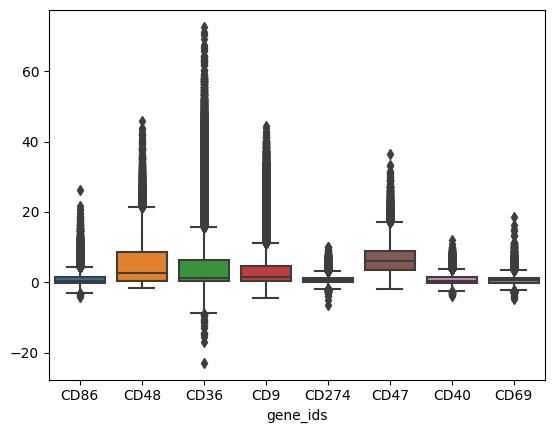

In [41]:
sns.boxplot(data=private_test_target.to_df()[['CD86', 'CD48', 'CD36', 'CD9', 'CD274', 'CD47', 'CD40', 'CD69']])
plt.show()

In [11]:
def plot_column_ranges(data, min_range=0):
    column_ranges = np.ptp(data.to_df(), axis=0)  # Range = max - min for each column
#     for c in column_ranges:
#         print(c)
# sorted_gene_ids = gene_ids.sort_values(ascending=False)
    print(column_ranges.sort_values(ascending=False)[:100])
    # Get the column names whose range is greater than 20
    selected_columns = data.var_names[column_ranges > min_range]
    plt.figure(figsize=(15, 8))
    sns.violinplot(data=data.to_df()[selected_columns], scale='width', linewidth=0)
    # sns.stripplot(data=private_test_target.to_df()[selected_columns], jitter=True)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()

In [ ]:
plot_column_ranges(private_test_target, min_range=20)

gene_ids
CD2       96.873528
CD36      95.543747
CD11c     89.022438
CD7       74.648659
CD328     71.216217
            ...    
CD56      11.814425
CD268     11.567720
CD24      11.536167
CX3CR1    11.224331
CD95      11.096481
Length: 100, dtype: float32


gene_ids
ENSG00000105205_CLC      11.089324
ENSG00000122862_SRGN     11.010873
ENSG00000244734_HBB      10.989997
ENSG00000167996_FTH1     10.872200
ENSG00000090382_LYZ      10.560007
                           ...    
ENSG00000166794_PPIB      8.124482
ENSG00000197746_PSAP      8.111321
ENSG00000260314_MRC1      8.103045
ENSG00000117450_PRDX1     8.096566
ENSG00000140749_IGSF6     8.087468
Length: 100, dtype: float32


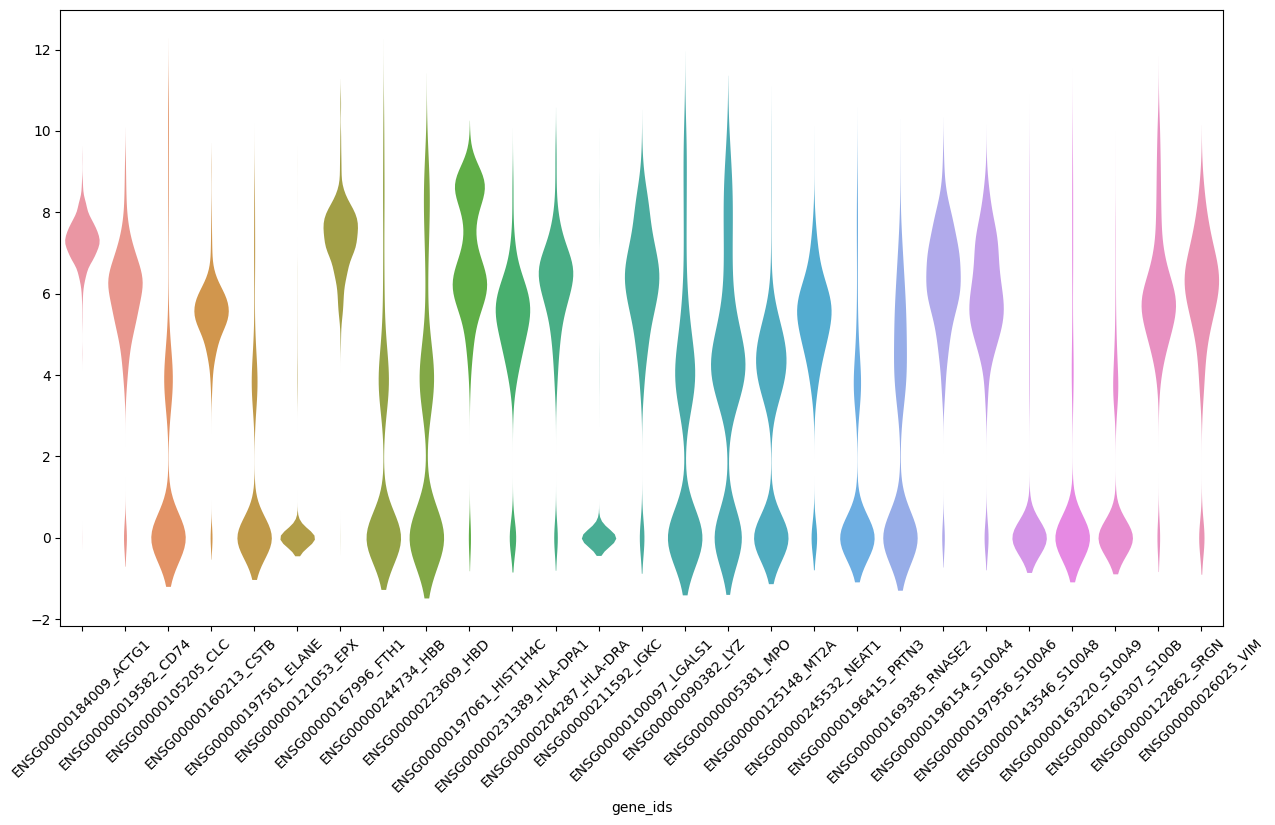

In [44]:
X_train_p_sampled = ad.read_h5ad('4.model/pred/private_train_input_max_samples.h5ad')
plot_column_ranges(X_train_p_sampled, min_range=9)    # 22085 columns, median 4, max 11, min 0

gene_ids
ENSG00000135218_CD36    7.783067
dtype: float32


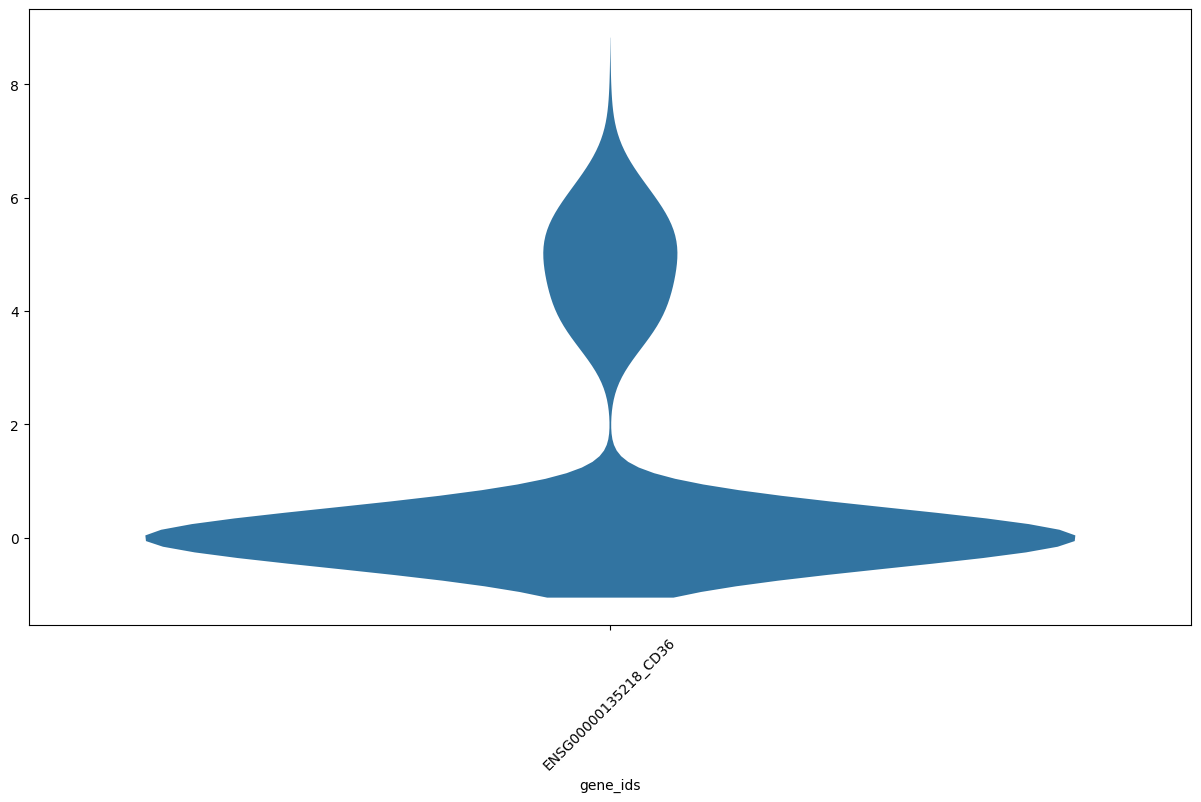

In [45]:
# col CD36:
cd36 = [col for col in X_train_p_sampled.var_names if col.endswith('CD36')]
plot_column_ranges(X_train_p_sampled[:, cd36])

gene_ids
ENSG00000105205_CLC       11.463948
ENSG00000251562_MALAT1    11.332369
ENSG00000167996_FTH1      11.110754
ENSG00000122862_SRGN      11.047930
ENSG00000196565_HBG2      10.996534
                            ...    
ENSG00000117984_CTSD       8.110641
ENSG00000115053_NCL        8.110023
ENSG00000197253_TPSB2      8.103555
ENSG00000124614_RPS10      8.101512
ENSG00000136167_LCP1       8.095597
Length: 100, dtype: float32


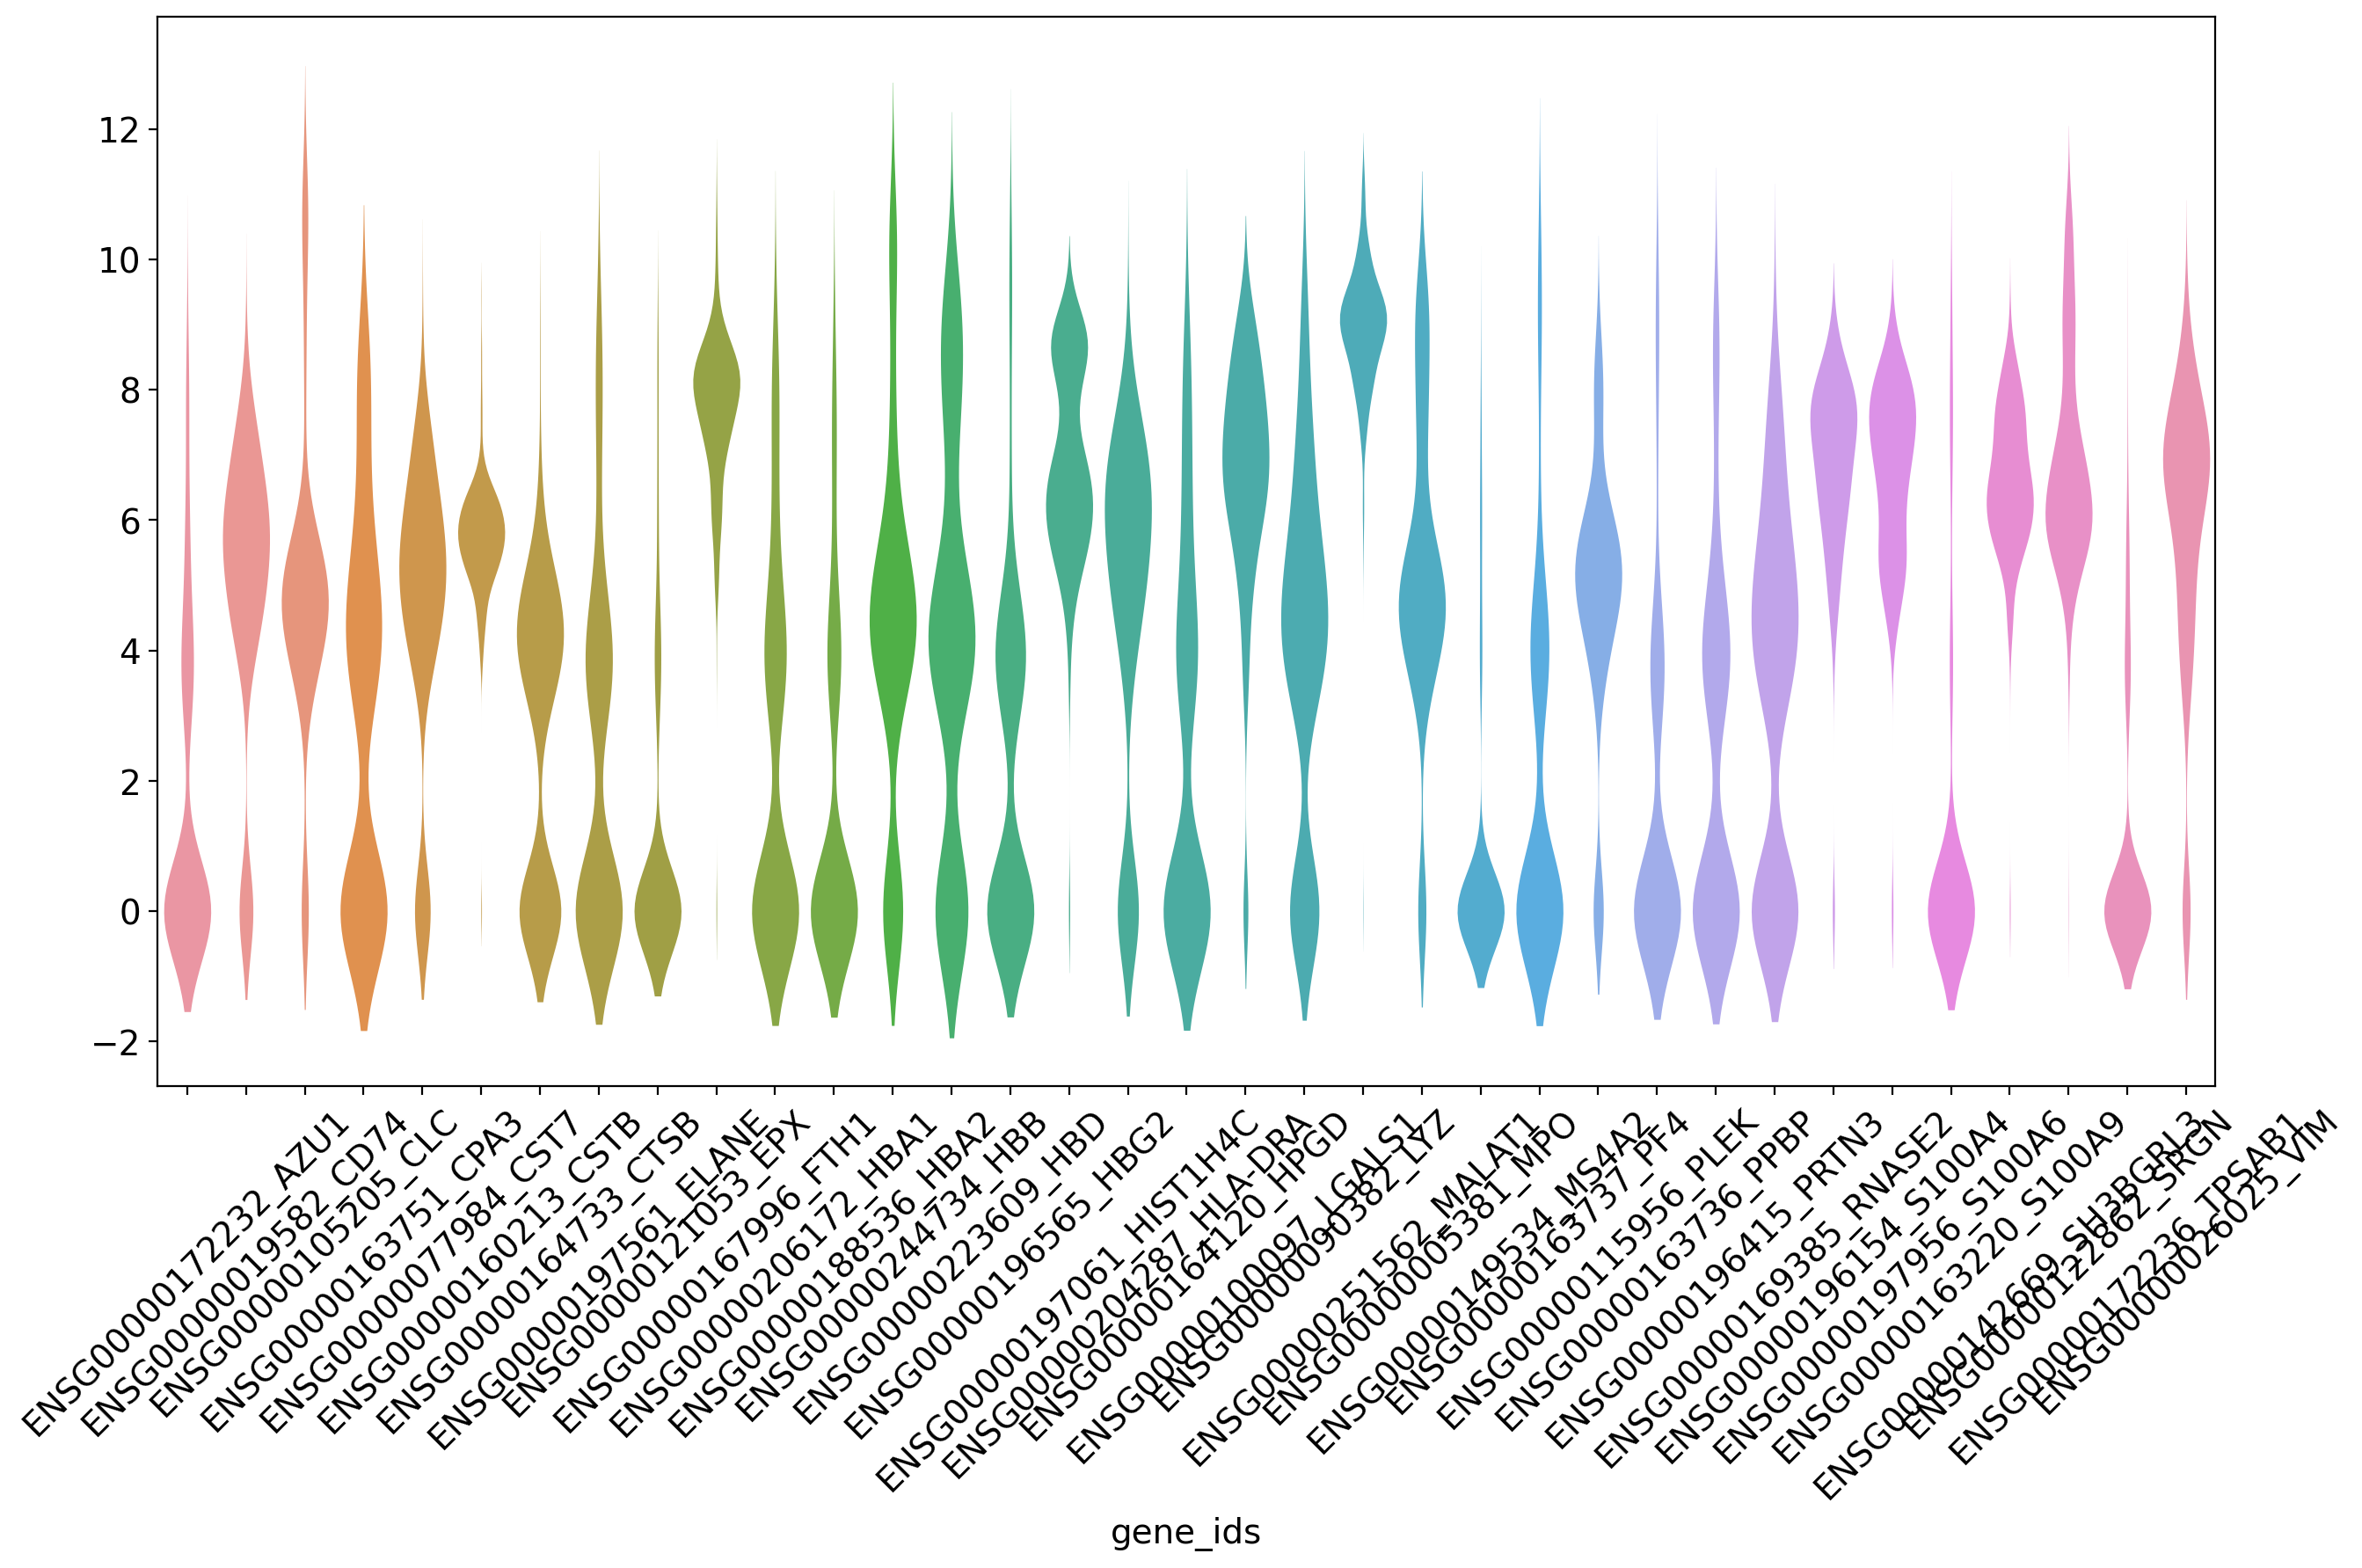

In [14]:
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private.pkl')
xtest = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
sample_cells = np.array(xtest.obs_names)
xtest_all_genes = private_test_input_raw.loc[sample_cells]
plot_column_ranges(ad.AnnData(xtest_all_genes.astype('float32')), 9)

gene_ids
ENSG00000114013_CD86    5.797295
dtype: float32


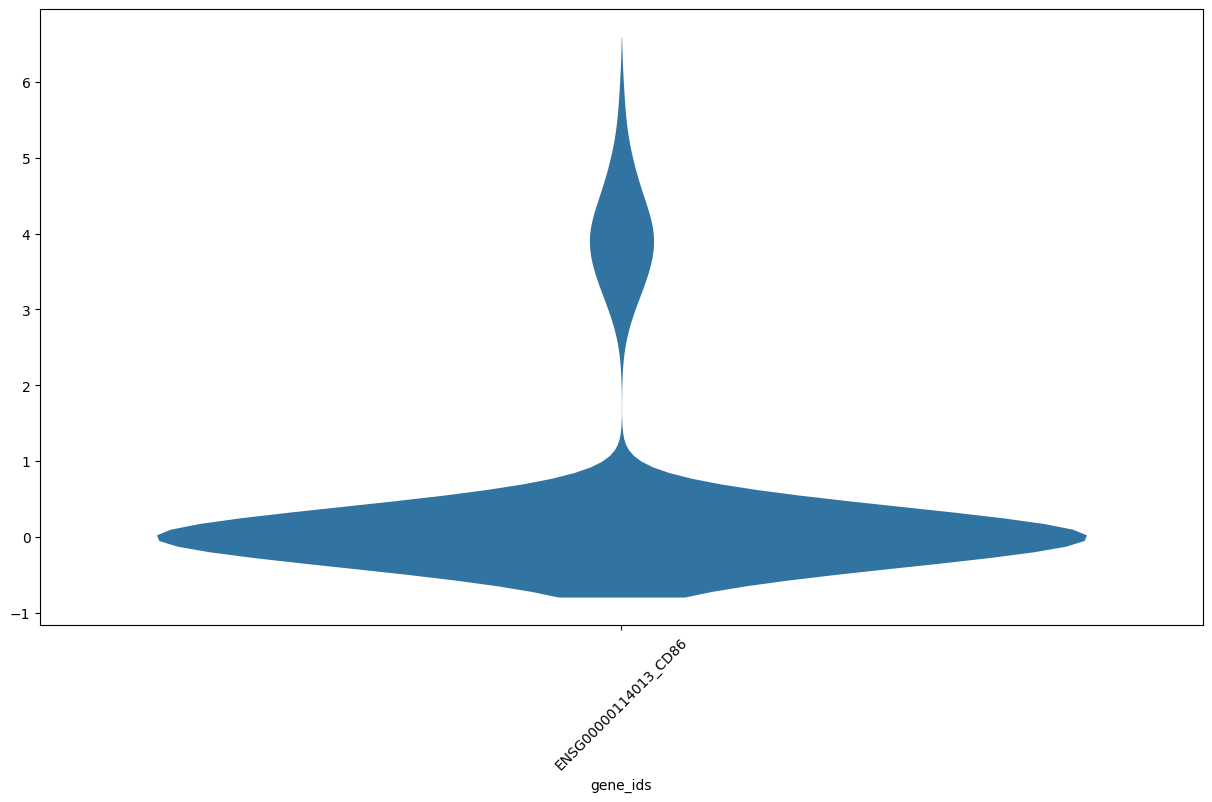

In [47]:
# col CD36:
gene = [col for col in X_train_p_sampled.var_names if col.endswith('CD86')]
plot_column_ranges(ad.AnnData(xtest_all_genes[gene].astype('float32')))

In [15]:
xtest_all_genes[[get_gene_name('CD86')[0], get_gene_name('CD4')[0], get_gene_name('CD7')[0], get_gene_name('CD36')[0], get_gene_name('CD9')[0], get_gene_name('CD48')[0]]]

gene_ids,ENSG00000114013_CD86,ENSG00000010610_CD4,ENSG00000173762_CD7,ENSG00000135218_CD36,ENSG00000010278_CD9,ENSG00000117091_CD48
"CTCCCTCGTATGAAAC-1-('32606', 7)",0.000000,0.000000,0.0,0.000000,5.078071,4.391136
"CATGCAATCGAAATCC-1-('27678', 7)",0.000000,0.000000,0.0,0.000000,0.000000,3.413380
"AAGCGAGGTTCATCGA-1-('31800', 7)",0.000000,0.000000,0.0,3.759869,0.000000,0.000000
"TTCGCTGAGAAAGTCT-1-('27678', 7)",0.000000,0.000000,0.0,0.000000,0.000000,0.000000
"TCCAGAACATCTCATT-1-('31800', 7)",3.998547,0.000000,0.0,0.000000,0.000000,5.593202
...,...,...,...,...,...,...
"CAGAGCCGTACCGGAA-1-('32606', 7)",0.000000,0.000000,0.0,0.000000,0.000000,5.582595
"TTGGGTAGTTACCTTT-1-('31800', 7)",0.000000,0.000000,0.0,4.306201,0.000000,0.000000
"AGACAGGCATGCTGCG-1-('13176', 7)",0.000000,0.000000,0.0,0.000000,0.000000,6.198090
"CGAGGAATCGCGAAGA-1-('32606', 7)",0.000000,3.521792,0.0,0.000000,0.000000,5.107309


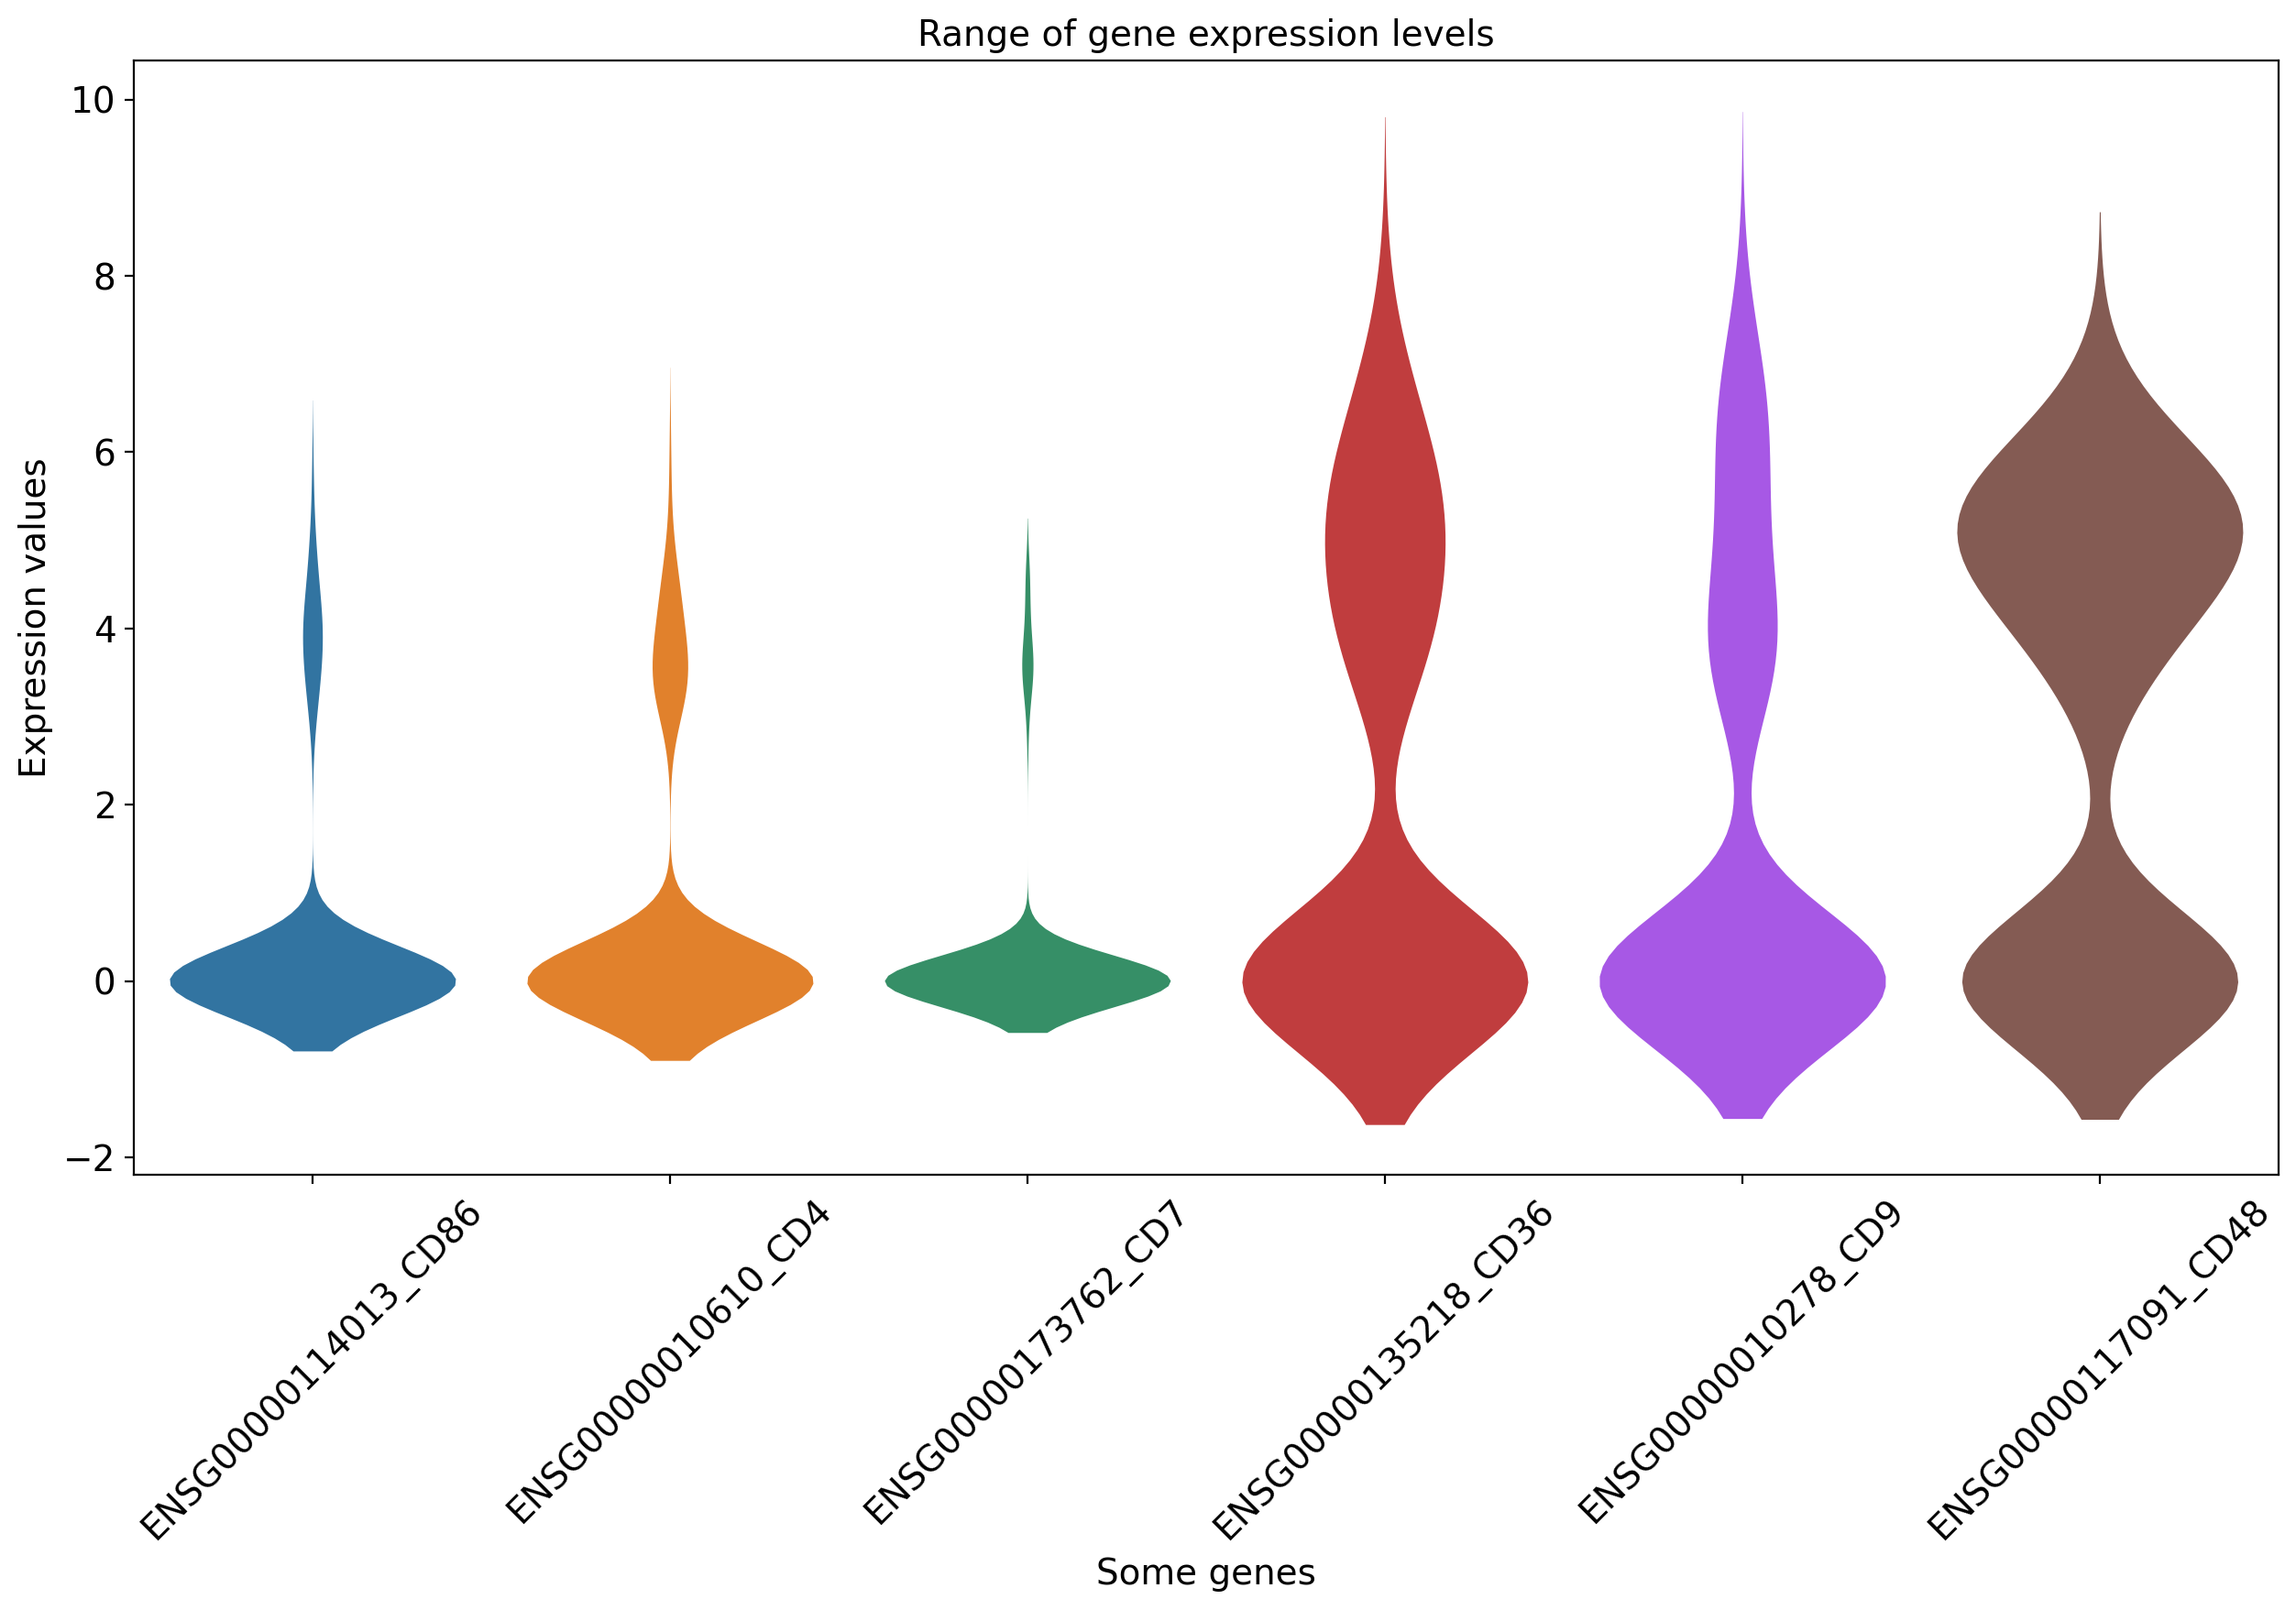

In [19]:
# selected_columns = data.var_names[column_ranges > min_range]
plt.figure(figsize=(15, 8))
sns.violinplot(data=xtest_all_genes[[get_gene_name('CD86')[0], get_gene_name('CD4')[0], get_gene_name('CD7')[0], get_gene_name('CD36')[0], get_gene_name('CD9')[0], get_gene_name('CD48')[0]]], scale='width', linewidth=0)
plt.xticks(rotation=45)
plt.xlabel('Some genes')
plt.ylabel('Expression values')
plt.title('Range of gene expression levels')
plt.grid(False)
plt.show()

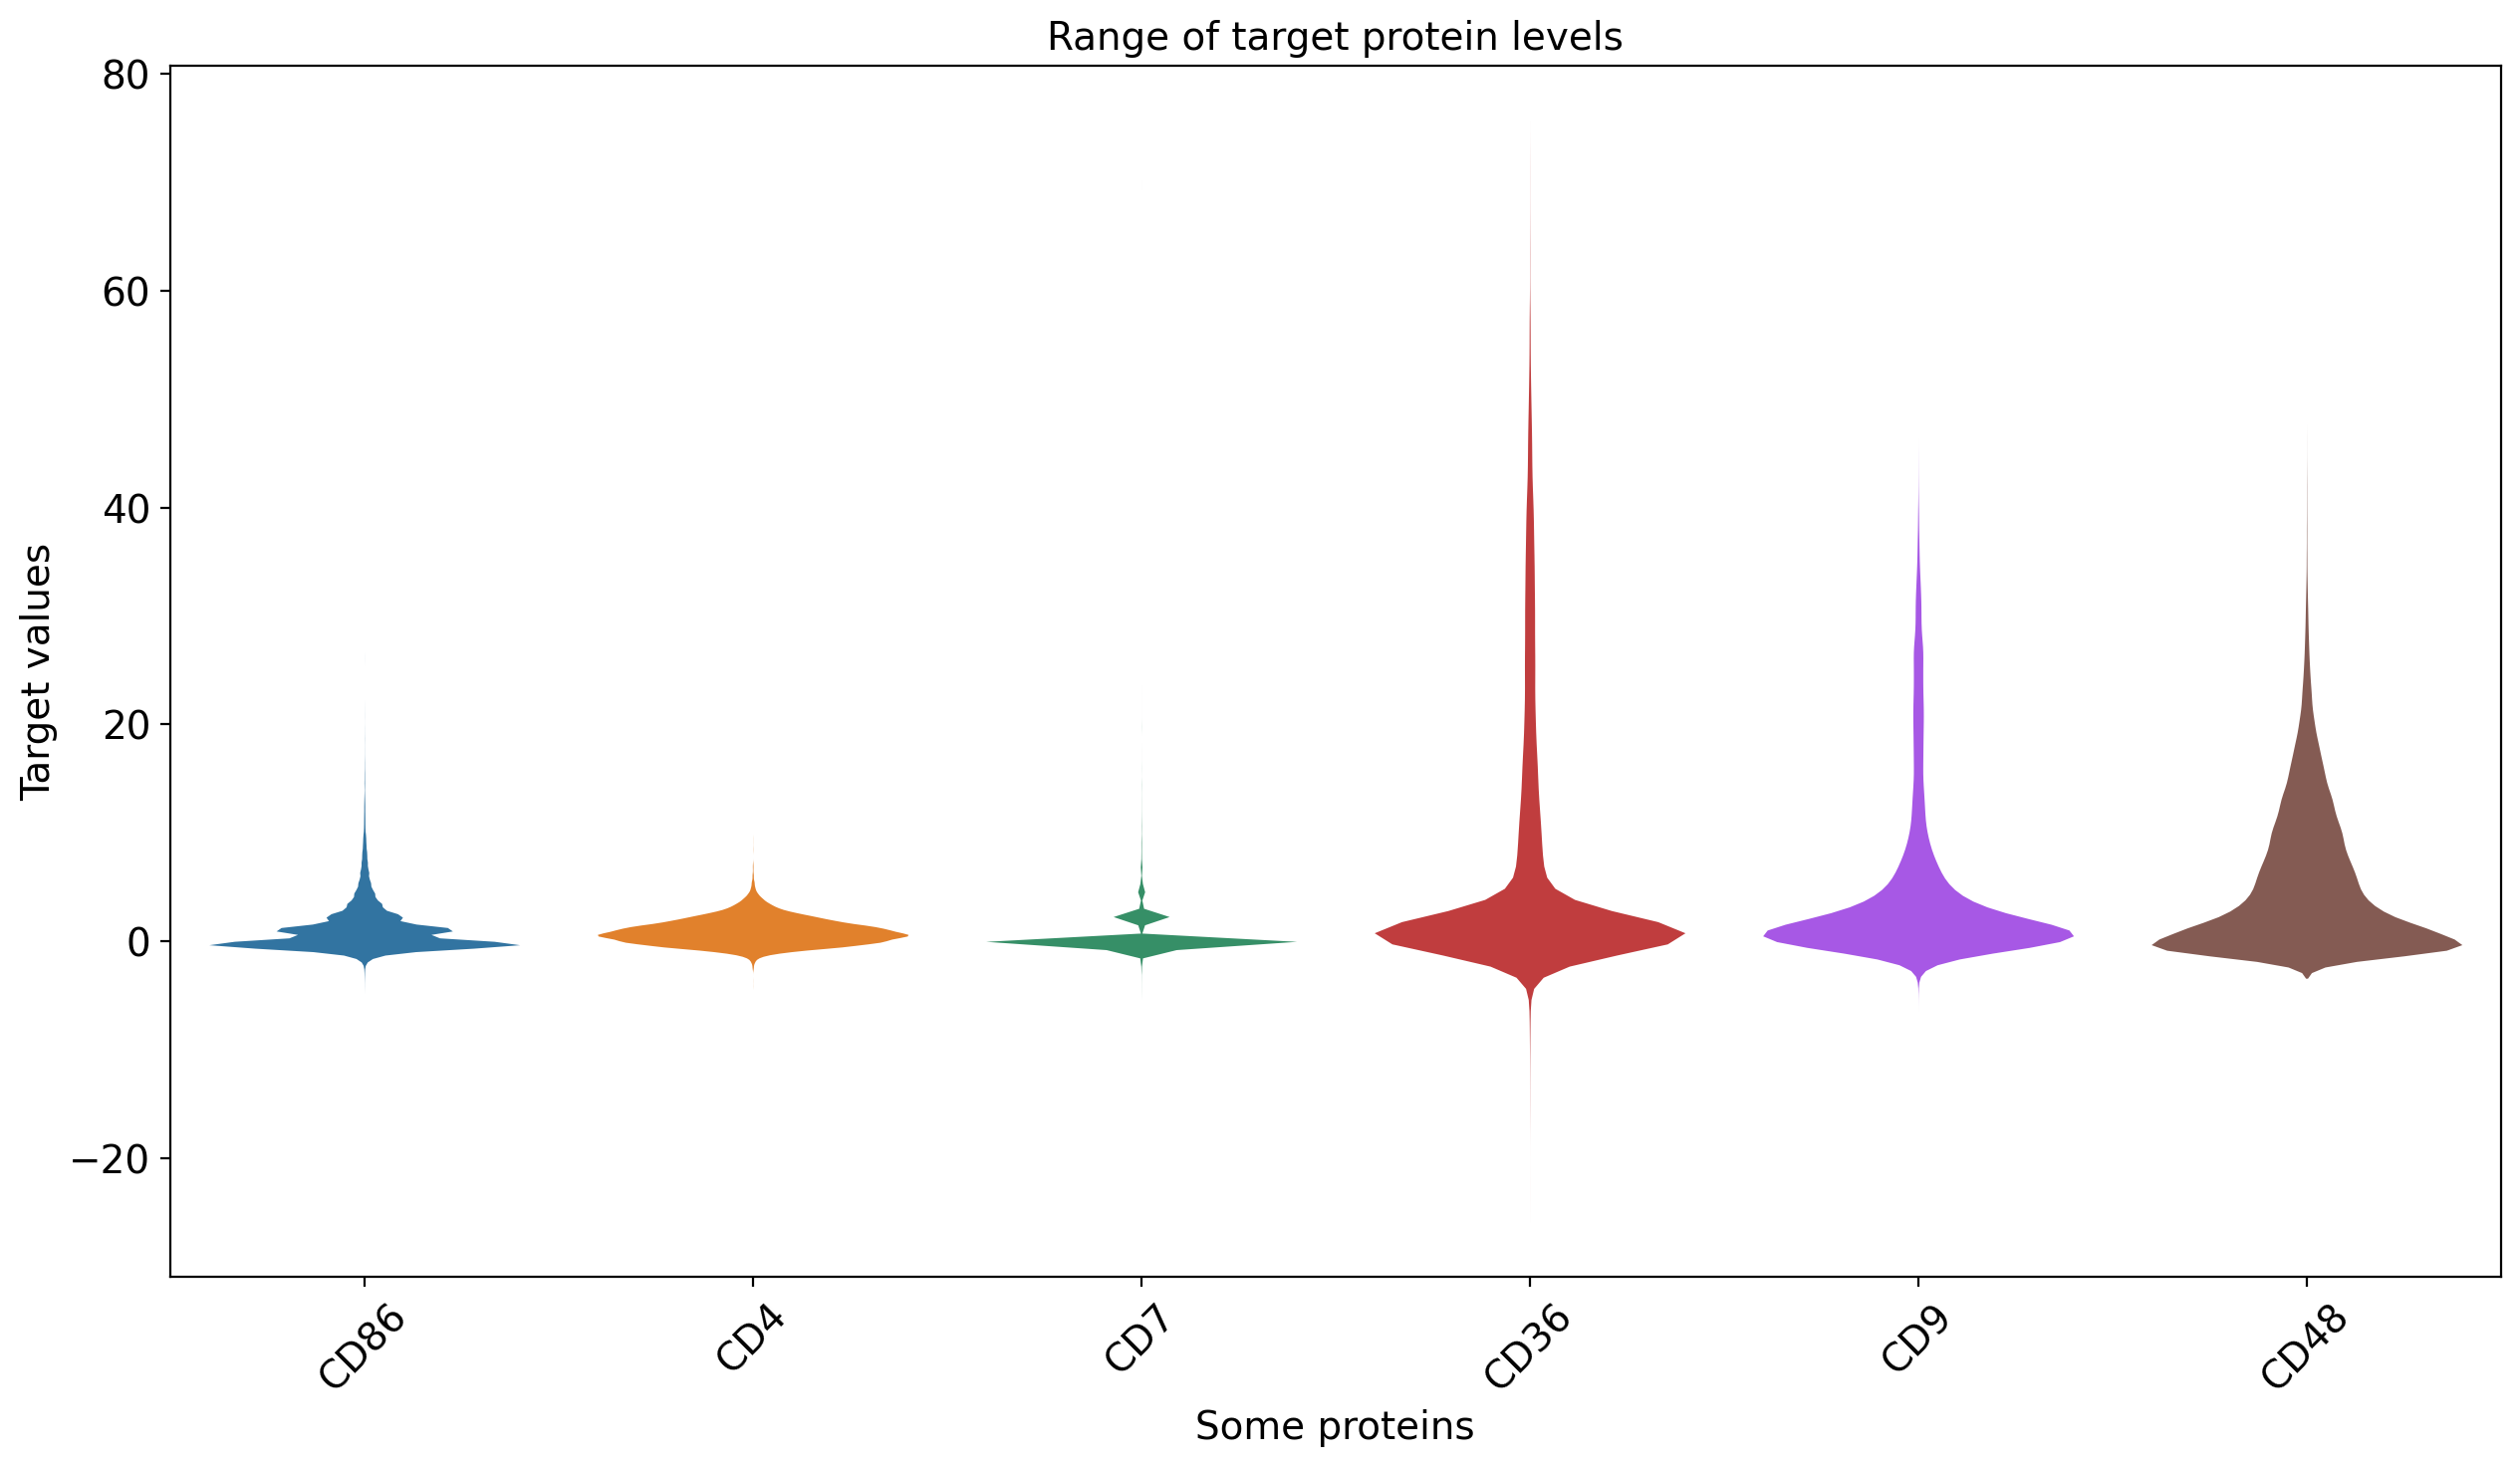

In [27]:
# same for protein values -> target

plt.figure(figsize=(15, 8))
sns.violinplot(data=private_test_target.to_df()[['CD86', 'CD4', 'CD7', 'CD36', 'CD9', 'CD48']], scale='width', linewidth=0)
# sns.stripplot(data=private_test_target.to_df()[['CD86', 'CD4', 'CD7', 'CD36', 'CD9', 'CD48']], jitter=True)
plt.xticks(rotation=45)
plt.xlabel('Some proteins')
plt.ylabel('Target values')
plt.title('Range of target protein levels')
plt.grid(False)
plt.show()